# Lluvias en Tabasco: ¿qué nos espera en 2025?

Tabasco es una de las regiones más lluviosas de México 🌴🌧️.
Aquí, la lluvia no es solo clima: marca la agricultura, la energía, la infraestructura… e incluso los riesgos de inundación.

En este proyecto me metí de lleno en 40 años de datos (1985–2025) para responder una pregunta clave:
👉 ¿qué podemos esperar de las lluvias en 2025?

El recorrido fue así:

1. Revisamos la historia → cómo se han comportado las lluvias mes a mes.

2. Identificamos patrones → meses con los aguaceros más intensos ☔, meses secos con sequía 🌵.

3. Analizaremos septiembre → el mes más sonado en el tema de las lluvias, un mes impredecible: a veces extremo, a veces tranquilo.

4. Predicción → con ARIMA proyectamos las lluvias de julio a diciembre 2025.

5. Conclusión → qué significa todo esto para agricultura, energía y protección civil.

La idea es simple: entender el pasado para anticipar el futuro 🔮.

***Carga y exploración de datos***

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Cargar datos
df = pd.read_csv("../lluvias_tabasco_data.csv")

# Resumen de contenido de dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16038 entries, 0 to 16037
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PERIODO        16038 non-null  object 
 1   CVE_ENT        16038 non-null  int64  
 2   ENTIDAD        16038 non-null  object 
 3   MINIMA         16038 non-null  float64
 4   MEDIA          16038 non-null  float64
 5   MAXIMA         16038 non-null  float64
 6   PRECIPITACION  16038 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 877.2+ KB


In [2]:
# Revisar el dataframe
print(df.head(10))

      PERIODO  CVE_ENT              ENTIDAD  MINIMA  MEDIA  MAXIMA  \
0  1985-01-01        0             Nacional     7.8   15.9    23.9   
1  1985-01-01        1       Aguascalientes     3.1   12.2    21.3   
2  1985-01-01        2      Baja California     5.6   12.9    20.2   
3  1985-01-01        3  Baja California Sur     9.2   17.1    25.0   
4  1985-01-01        4             Campeche    15.7   22.7    29.7   
5  1985-01-01        5             Coahuila     2.9   10.3    17.7   
6  1985-01-01        6               Colima    14.4   22.7    30.9   
7  1985-01-01        7              Chiapas    14.1   20.9    27.8   
8  1985-01-01        8            Chihuahua    -1.4    7.5    16.5   
9  1985-01-01        9     Ciudad de México     4.1   12.5    20.9   

   PRECIPITACION  
0           36.0  
1            4.9  
2           12.2  
3           30.3  
4           20.9  
5            1.1  
6           40.7  
7            8.1  
8          107.3  
9           54.6  


***Limpieza  y preprocesamiento de datos***

In [3]:
# Filtrar la columna "entidad" == "Tabasco"
df_tabasco = df[df["ENTIDAD"] == "Tabasco"].copy()

# Dar formato de fecha a la columna "PERIODO"
df_tabasco['PERIODO'] = pd.to_datetime(df['PERIODO'], errors='coerce')

# Cambiar nombres de columnas a minúsculas
df_tabasco.columns = df.columns.str.lower()

print(df_tabasco.head(10))

       periodo  cve_ent  entidad  minima  media  maxima  precipitacion
27  1985-01-01       27  Tabasco    17.5   22.3    27.0          189.3
60  1985-02-01       27  Tabasco    19.3   24.7    30.2           98.7
93  1985-03-01       27  Tabasco    19.9   25.9    31.9           94.7
126 1985-04-01       27  Tabasco    21.6   27.9    34.3          148.8
159 1985-05-01       27  Tabasco    22.9   29.1    35.3           97.4
192 1985-06-01       27  Tabasco    23.1   28.8    34.5          312.2
225 1985-07-01       27  Tabasco    22.7   28.3    33.8          268.4
258 1985-08-01       27  Tabasco    22.6   28.4    34.2          302.9
291 1985-09-01       27  Tabasco    22.6   28.0    33.5          260.8
324 1985-10-01       27  Tabasco    21.9   27.3    32.6          277.8


## 1. Revisamos la historia

In [4]:
# Crear columnas de año y mes
df_tabasco["año"] = df_tabasco["periodo"].dt.year
df_tabasco["mes"] = df_tabasco["periodo"].dt.month

# Seleccionar columnas de interés
df_tabasco = df_tabasco[["año", "mes", "precipitacion"]].rename(
    columns={"precipitacion":"precipitacion_mm"}
)

print("✅ Primer vistazo a los datos de Tabasco:")
print(df_tabasco.head(12))

#

✅ Primer vistazo a los datos de Tabasco:
      año  mes  precipitacion_mm
27   1985    1             189.3
60   1985    2              98.7
93   1985    3              94.7
126  1985    4             148.8
159  1985    5              97.4
192  1985    6             312.2
225  1985    7             268.4
258  1985    8             302.9
291  1985    9             260.8
324  1985   10             277.8
357  1985   11             220.0
390  1985   12             222.0


Ya tenemos organizada la información en año, mes y milímetros de lluvia.
Esto nos permitirá explorar los patrones históricos con claridad.

## 2. IDENTIFICAMOS PATRONES → meses más lluviosos vs secos

C:\Users\jteno\AppData\Local\Temp\ipykernel_12936\299299562.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  promedio_lluvia_mes = df_tabasco.groupby("mes_nombre")["precipitacion_mm"].mean()


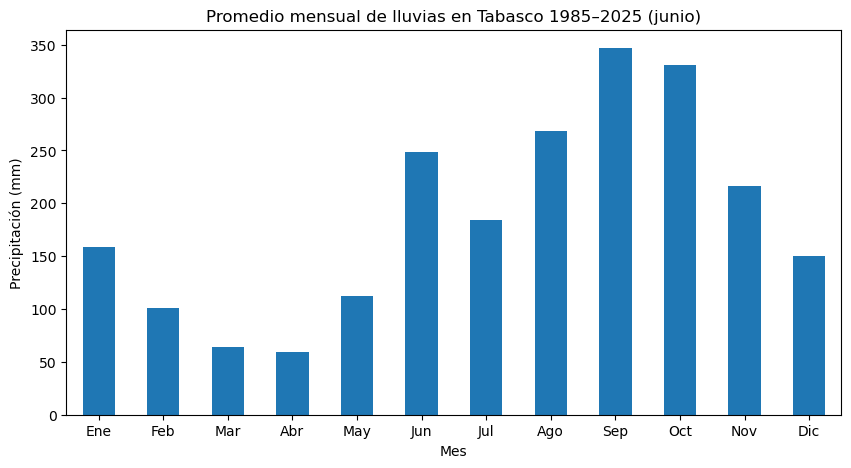

In [5]:
# Diccionario para convertir número de mes a nombre
meses_dict = {
    1:"Ene", 2:"Feb", 3:"Mar", 4:"Abr",
    5:"May", 6:"Jun", 7:"Jul", 8:"Ago",
    9:"Sep", 10:"Oct", 11:"Nov", 12:"Dic"
}

# Crear nueva columna con nombres
df_tabasco["mes_nombre"] = df_tabasco["mes"].map(meses_dict)

# Crear columna de categoría con orden cronológico
df_tabasco["mes_nombre"] = pd.Categorical(
    df_tabasco["mes_nombre"],
    categories=["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"],
    ordered=True
)


# Calcular promedio histórico de lluvia por mes
promedio_lluvia_mes = df_tabasco.groupby("mes_nombre")["precipitacion_mm"].mean()

# Graficar
plt.figure(figsize=(10,5))
promedio_lluvia_mes.plot(kind="bar", x="mes_nombre", y="precipitacion_mm")
plt.title("Promedio mensual de lluvias en Tabasco 1985–2025 (junio)")
plt.xlabel("Mes")
plt.ylabel("Precipitación (mm)")
plt.xticks(rotation=0)
plt.legend().remove()
plt.show()


Septiembre y octubre son los meses con más lluvias ☔, mientras que abril y marzo son los más secos 🌵.

## 3. Análisis de septiembre

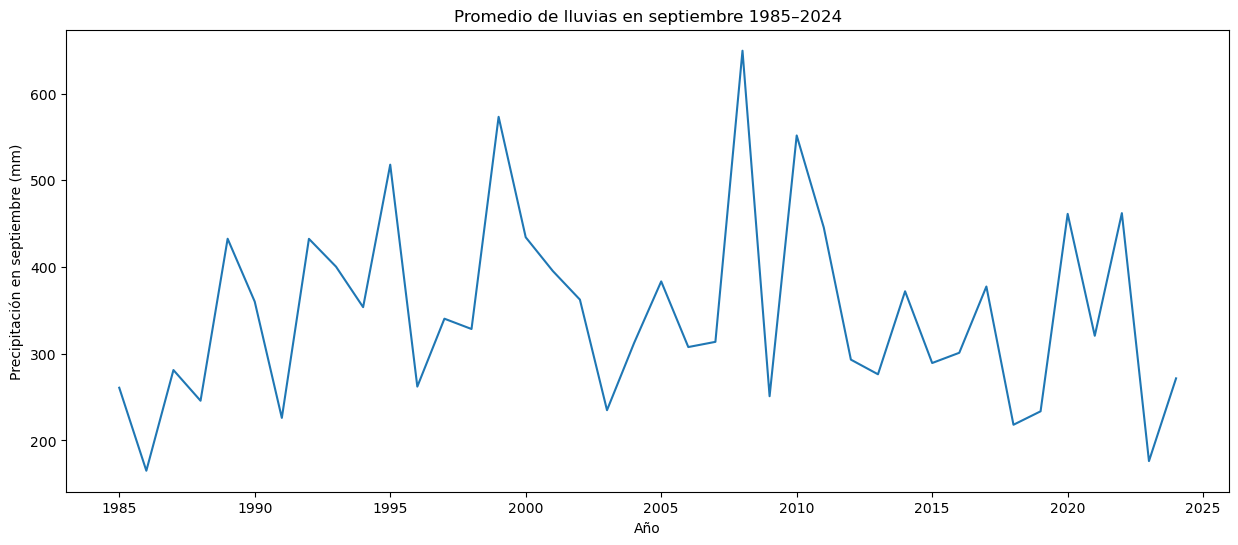

In [6]:
# Filtrar solo septiembre y agrupar por año
lluvia_septiembre = df_tabasco[df_tabasco["mes"] == 9].groupby("año")["precipitacion_mm"].sum()

# Graficar tendencia histórica de septiembre
plt.figure(figsize=(15,6))
lluvia_septiembre.plot()
plt.title("Promedio de lluvias en septiembre 1985–2024")
plt.xlabel("Año")
plt.ylabel("Precipitación en septiembre (mm)")
plt.show()


Septiembre es muy variable: algunos años con lluvias extremas, otros con registros más moderados. Aquí es donde se definen
muchos riesgos de inundación.

## 4. Predicción modelo ARIMA

📅 Predicción de lluvias en Tabasco (jul–dic 2025):
       Fecha  Precipitación_predicha_mm  IC_inferior_mm  IC_superior_mm
0 2025-07-01                 201.015237             0.0      424.027072
1 2025-08-01                 192.842367             0.0      438.711097
2 2025-09-01                 189.065340             0.0      439.633360
3 2025-10-01                 187.319818             0.0      438.920531
4 2025-11-01                 186.513139             0.0      438.352541
5 2025-12-01                 186.140339             0.0      438.039342


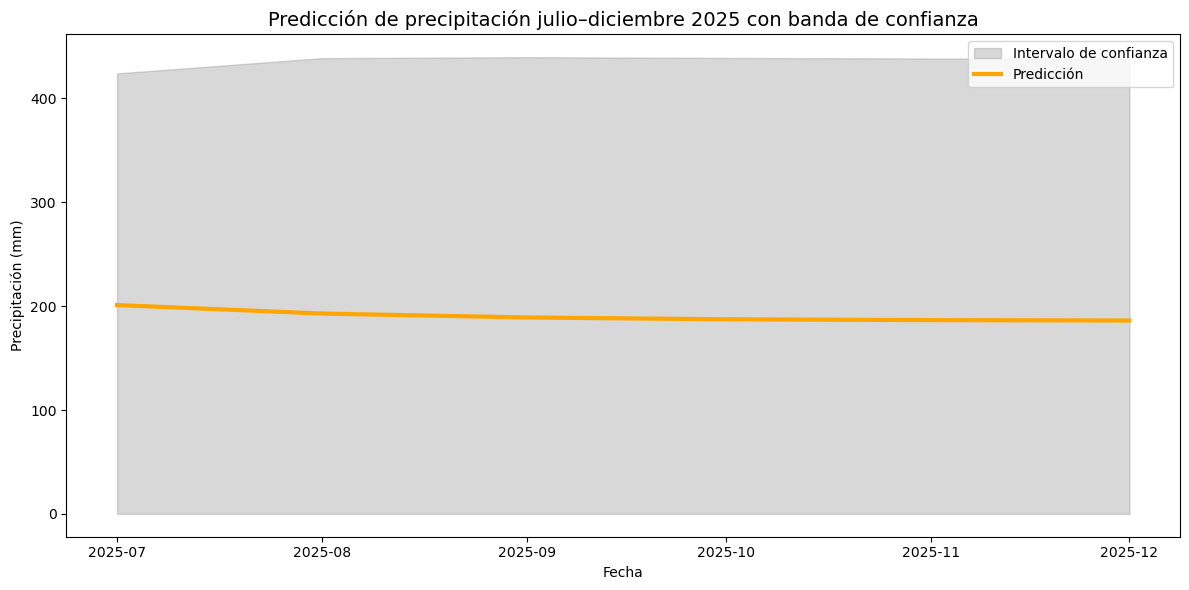

In [7]:
# Copiar datos
df_mensual = df_tabasco.copy()

# Crear columna "fecha" correctamente
df_mensual["fecha"] = pd.to_datetime({
    "year": df_mensual["año"],
    "month": df_mensual["mes"],
    "day": 1
})

# Construir serie temporal mensual
serie = df_mensual.set_index("fecha")["precipitacion_mm"].resample("ME").sum()

# Filtrar hasta junio 2025
serie = serie[serie.index <= "2025-06-30"]

# Entrenar modelo ARIMA
modelo = ARIMA(serie, order=(1,1,1))
resultado = modelo.fit()

# Predecir 6 meses: julio a diciembre 2025
forecast = resultado.get_forecast(steps=6)
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

# Definir índice de fechas para julio–diciembre 2025
fechas_pred = pd.date_range(start="2025-07-01", periods=6, freq="MS")

# Crear DataFrame con predicción y IC
df_pred = pd.DataFrame({
    "Precipitación_predicha_mm": pred.values,
    "IC_inferior_mm": conf_int.iloc[:,0].values,
    "IC_superior_mm": conf_int.iloc[:,1].values
}, index=fechas_pred)

# Redondear IC inferiror a 0 como mínimo 
df_pred["IC_inferior_mm"] = df_pred["IC_inferior_mm"].clip(lower=0)

df_pred = df_pred.reset_index().rename(columns={"index": "Fecha"})

# Mostrar resultados
print("📅 Predicción de lluvias en Tabasco (jul–dic 2025):")
print(df_pred)

# Crear figura
plt.figure(figsize=(12,6))

# Banda de confianza (área sombreada)
plt.fill_between(
    df_pred["Fecha"],
    df_pred["IC_inferior_mm"],
    df_pred["IC_superior_mm"],
    color="gray",
    alpha=0.3,
    label="Intervalo de confianza"
)

# Línea de predicción
plt.plot(
    df_pred["Fecha"],
    df_pred["Precipitación_predicha_mm"],
    color="orange",
    linewidth=3,
    label="Predicción"
)

# Ajustes estéticos
plt.title("Predicción de precipitación julio–diciembre 2025 con banda de confianza", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Precipitación (mm)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

El modelo ARIMA nos da una ventana a lo que podría pasar con las lluvias de julio a diciembre 2025. Los intervalos de confianza amplios nos recuerdan que el clima es impredecible, pero aún así tenemos un rango de incertidumbre que nos da un panorama de posibilidades climatológicas.

## 5. Conclusión

Las lluvias en Tabasco no son solo un fenómeno climatológico: moldean la economía y la vida diaria.

* Agricultura 🌱: Septiembre y octubre siguen siendo críticos; la variabilidad puede afectar cosechas.

* Energía ⚡: La disponibilidad hídrica influye en hidroeléctricas y demanda energética.

* Protección civil 🛑: Con estos patrones podemos prever inundaciones y reducir riesgos.

Usar datos históricos y crear predicciones conn  un modelo ARIMA es como tener mapa y brújula para enfrentar la temporada de lluvias este 2025.